In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####Imports

In [ ]:
!pip install -U albumentations

!pip install --upgrade opencv-python
import cv2
print(cv2.__version__)#4.5.5
import albumentations as A
print(A.__version__)#1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
4.6.0
1.2.0


In [ ]:
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms as T
import torch.nn as nn
from tqdm import tqdm
import os
import PIL.Image
import pandas as pd
import scipy.io
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch
from albumentations.pytorch import ToTensorV2

####Setting a seed

In [ ]:
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

### Some images from the dataset and thire matchin lables


In [ ]:
img_labels = (scipy.io.loadmat("/content/drive/Shareddrives/ML./Ass3/imagelabels.mat")['labels'][0]).tolist()
img_dir = "/content/drive/Shareddrives/ML./Ass3/102flowers/jpg"
# the sort is to make sure that the images and lables are matching
img_list = sorted(os.listdir(img_dir))

46


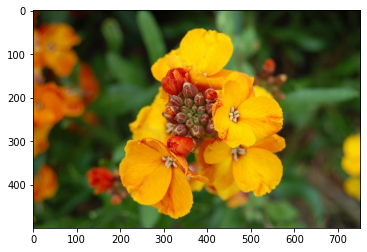

In [ ]:
idx = 1002
img_path = os.path.join(img_dir, img_list[idx])
image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
label = img_labels[idx]

print(label)
plt.imshow(image)
plt.show()

46


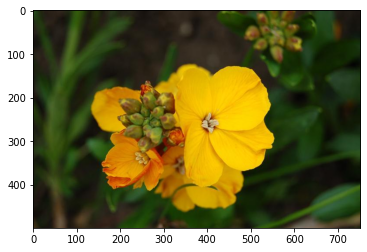

In [ ]:
idx = 1005
img_path = os.path.join(img_dir, img_list[idx])
image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
label = img_labels[idx]

print(label)
plt.imshow(image)
plt.show()

46


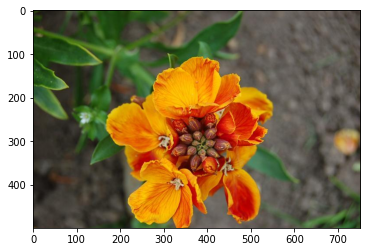

In [ ]:
idx = 1004
img_path = os.path.join(img_dir, img_list[idx])
image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
label = img_labels[idx]

print(label)
plt.imshow(image)
plt.show()

####Creating custom dataset for the dataloder


In [ ]:
def int_to_onehot(y, num_labels = 102):
    ary = np.zeros(num_labels)
    ary[y-1] = 1
    return ary

In [ ]:
class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir):
    self.img_labels = scipy.io.loadmat(annotations_file)['labels'][0]
    # the sort is to make sure that the imaes and the lables are matched
    self.img_list = sorted(os.listdir(img_dir)) 
    self.img_dir = img_dir

  def __len__(self):
    return len(self.img_list)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_list[idx])
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    label = self.img_labels[idx]
    return image, int_to_onehot(label)

class CustomSubset(Dataset):
  def __init__(self, dataset, indices, transform):
    self.dataset = dataset
    self.indices = indices
    self.transform = transform

  def __getitem__(self, idx):
    im, labels = self.dataset[self.indices[idx]]
    return self.transform(image=im)['image'], labels

  def __len__(self):
    return len(self.indices)

In [ ]:
scale = 1.1
IMAGE_SIZE = 128
train_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
        A.PadIfNeeded(
            min_height=int(IMAGE_SIZE * scale),
            min_width=int(IMAGE_SIZE * scale),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.RandomCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
        A.ShiftScaleRotate(rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
        A.CLAHE(p=0.1),
        A.Posterize(p=0.1),
        A.ToGray(p=0.1),
        A.ChannelShuffle(p=0.05),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255),
        ToTensorV2()
    ])

test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
        A.PadIfNeeded(
            min_height=int(IMAGE_SIZE * scale),
            min_width=int(IMAGE_SIZE * scale),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.CenterCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255),
        ToTensorV2()
    ])

In [ ]:
dataset102 = CustomImageDataset("/content/drive/Shareddrives/ML./Ass3/imagelabels.mat", 
                             "/content/drive/Shareddrives/ML./Ass3/102flowers/jpg")

In [ ]:
def create_data_loader(dataset):
  # Creating 3 splits of the data
  temp_indices, test_indices = train_test_split(list(range(len(dataset.img_labels))), test_size=0.25, stratify=dataset.img_labels)
  temp_dataset = torch.utils.data.Subset(dataset, temp_indices)
  test_dataset = CustomSubset(dataset, test_indices, test_transforms)

  train_indices, val_indices = train_test_split(list(range(len(temp_dataset.dataset.img_labels[temp_indices]))), test_size=0.333, stratify=temp_dataset.dataset.img_labels[temp_indices])
  val_dataset = CustomSubset(temp_dataset, val_indices, test_transforms)
  train_dataset = CustomSubset(temp_dataset, train_indices, train_transforms)

  batch_size_train = 32
  batch_size_val = 512
  batch_size_test = 512

  train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=batch_size_train, shuffle=True, num_workers = 2)
  train_size = len(train_loader.dataset)

  val_loader = torch.utils.data.DataLoader(val_dataset,
    batch_size=batch_size_test, shuffle=False, num_workers = 2)
  val_size = len(val_loader.dataset)

  test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=batch_size_test, shuffle=False, num_workers = 2)
  test_size = len(test_loader.dataset)

  print(f"---train/test split is:----")
  print(f"Train size is:{train_size}, - {np.argmax(train_loader.dataset[0][1])},{np.argmax(train_loader.dataset[1][1])},{np.argmax(train_loader.dataset[2][1])}")
  print(f"Eval size is:{val_size}, - {np.argmax(val_loader.dataset[0][1])},{np.argmax(val_loader.dataset[1][1])},{np.argmax(val_loader.dataset[2][1])}")
  print(f"Test size is:{test_size}, - {np.argmax(test_loader.dataset[0][1])},{np.argmax(test_loader.dataset[1][1])},{np.argmax(test_loader.dataset[2][1])}")

  return train_loader, val_loader, test_loader

In [ ]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

cuda


In [ ]:
def train(epoch, network, optimizer, loader):
  network.train()

  correct = 0
  train_losses = []
  total= 0

  progress_bar = tqdm(enumerate(loader), desc=f'Epoch {epoch}', total=len(loader))
  prog_bar_desc = 'Loss: {:.4}, accuracy: {:.4}'

  for batch_idx, (data, target) in progress_bar:
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()

    output = network(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()

    targetNumber = target.max(1)[1]
    pred = output.max(1)[1]
    correct += pred.eq(targetNumber).sum()
    total+= len(data)
    epoc_acc = correct * 100. / total
    epoc_loss = sum(train_losses)/(batch_idx+1)

    train_losses.append(loss.item())
    progress_bar.set_postfix_str(
                prog_bar_desc.format(epoc_loss, epoc_acc))
    
  return epoc_acc.item(), epoc_loss

In [ ]:
def progres(network, loader):
  loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in tqdm(loader):
      data = data.to(device)
      target = target.to(device)
      output = network(data)

      loss += F.cross_entropy(output, target).item()
      pred = output.max(1)[1]
      targetNumber = target.max(1)[1]
      correct += pred.eq(targetNumber).sum()
  return correct, loss

In [ ]:
def evaluation(network, loader):
  network.eval()

  correct, eval_loss = progres(network, loader)

  eval_loss /= len(loader)
  test_acc_torch = 100. * correct / len(loader.dataset)

  print('\Evaluation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    eval_loss, correct, 
    len(loader.dataset),
    test_acc_torch))
  
  return test_acc_torch.item(), eval_loss

In [ ]:
def test(network, loader):
  network.eval()

  correct, test_loss = progres(network, loader)

  test_loss /= len(loader)
  test_acc_torch = 100. * correct / len(loader.dataset)

  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, 
    len(loader.dataset),
    test_acc_torch))
  
  return test_acc_torch.item(), test_loss

In [ ]:
def run_network(network, n_epochs, learning_rate):
  train_loader, val_loader, test_loader = create_data_loader(dataset102)

  train_acc_for_graph = []
  train_loss_for_graph = []
  test_acc_for_graph = 0
  test_loss_for_graph = 0
  val_acc_for_graph = []
  val_loss_for_graph = []

  optimizer = optim.SGD(network.parameters(), lr=learning_rate)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True, factor=0.5 )

  print(f"----Start the trainig procedure---")
  for epoch in range(1, n_epochs + 1):

    epoc_acc, epoc_loss = train(epoch, network, optimizer, train_loader)
    train_acc_for_graph.append(epoc_acc)
    train_loss_for_graph.append(epoc_loss)

    epoc_acc, epoc_loss = evaluation(network, val_loader)
    val_acc_for_graph.append(epoc_acc)
    val_loss_for_graph.append(epoc_loss)

    scheduler.step(val_loss_for_graph[-1])

  print(f"----End of trainig procedure---")
  test_acc_for_graph, test_loss_for_graph = test(network, test_loader)

  return train_acc_for_graph, train_loss_for_graph, test_acc_for_graph, test_loss_for_graph, val_acc_for_graph, val_loss_for_graph

In [ ]:
def creat_graphs(num_of_epochs, train_acc_for_graph, train_loss_for_graph, test_acc_for_graph, test_loss_for_graph, val_acc_for_graph, val_loss_for_graph):
  epochs = range(1,num_of_epochs+1)
  plt.plot(epochs, train_acc_for_graph, 'g', label='Training Accuracy')
  plt.plot(epochs, val_acc_for_graph, 'b', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, train_loss_for_graph, 'g', label='Training Loss')
  plt.plot(epochs, val_loss_for_graph, 'b', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  print(f"Test accuracy is: {test_acc_for_graph}")
  print(f"Test loss is: {test_loss_for_graph}")
  print(f"__________________________________________________________________________________________________")

---train/test split is:----
Train size is:4096, - 90,73,83
Eval size is:2045, - 45,67,14
Test size is:2048, - 93,82,13
----Start the trainig procedure---


100%|██████████| 4/4 [00:16<00:00,  4.13s/it]

\Evaluation set: Avg. loss: 1.3250, Accuracy: 1337/2045 (65.38%)




100%|██████████| 4/4 [00:15<00:00,  3.88s/it]

\Evaluation set: Avg. loss: 1.0187, Accuracy: 1458/2045 (71.30%)




100%|██████████| 4/4 [00:16<00:00,  4.08s/it]

\Evaluation set: Avg. loss: 0.8175, Accuracy: 1581/2045 (77.31%)




100%|██████████| 4/4 [00:12<00:00,  3.06s/it]

\Evaluation set: Avg. loss: 0.6836, Accuracy: 1644/2045 (80.39%)




100%|██████████| 4/4 [00:12<00:00,  3.00s/it]

\Evaluation set: Avg. loss: 0.6949, Accuracy: 1650/2045 (80.68%)




100%|██████████| 4/4 [00:11<00:00,  2.98s/it]

\Evaluation set: Avg. loss: 0.6267, Accuracy: 1684/2045 (82.35%)




100%|██████████| 4/4 [00:11<00:00,  2.95s/it]

\Evaluation set: Avg. loss: 0.6307, Accuracy: 1681/2045 (82.20%)




100%|██████████| 4/4 [00:11<00:00,  2.99s/it]

\Evaluation set: Avg. loss: 0.5744, Accuracy: 1707/2045 (83.47%)




100%|██████████| 4/4 [00:11<00:00,  2.95s/it]

\Evaluation set: Avg. loss: 0.5698, Accuracy: 1713/2045 (83.77%)




100%|██████████| 4/4 [00:11<00:00,  2.95s/it]

\Evaluation set: Avg. loss: 0.4707, Accuracy: 1786/2045 (87.33%)




100%|██████████| 4/4 [00:12<00:00,  3.00s/it]

\Evaluation set: Avg. loss: 0.5186, Accuracy: 1744/2045 (85.28%)




100%|██████████| 4/4 [00:11<00:00,  2.99s/it]

\Evaluation set: Avg. loss: 0.5134, Accuracy: 1752/2045 (85.67%)




100%|██████████| 4/4 [00:11<00:00,  2.95s/it]

\Evaluation set: Avg. loss: 0.4719, Accuracy: 1777/2045 (86.89%)




100%|██████████| 4/4 [00:11<00:00,  2.98s/it]

\Evaluation set: Avg. loss: 0.4944, Accuracy: 1755/2045 (85.82%)

Epoch 00014: reducing learning rate of group 0 to 2.0000e-02.



100%|██████████| 4/4 [00:11<00:00,  2.98s/it]

\Evaluation set: Avg. loss: 0.3546, Accuracy: 1829/2045 (89.44%)




100%|██████████| 4/4 [00:13<00:00,  3.37s/it]

\Evaluation set: Avg. loss: 0.3480, Accuracy: 1840/2045 (89.98%)




100%|██████████| 4/4 [00:11<00:00,  2.93s/it]

\Evaluation set: Avg. loss: 0.3691, Accuracy: 1821/2045 (89.05%)




100%|██████████| 4/4 [00:11<00:00,  2.96s/it]

\Evaluation set: Avg. loss: 0.3547, Accuracy: 1825/2045 (89.24%)




100%|██████████| 4/4 [00:11<00:00,  2.97s/it]

\Evaluation set: Avg. loss: 0.3695, Accuracy: 1821/2045 (89.05%)




100%|██████████| 4/4 [00:11<00:00,  2.95s/it]

\Evaluation set: Avg. loss: 0.3704, Accuracy: 1824/2045 (89.19%)

Epoch 00020: reducing learning rate of group 0 to 1.0000e-02.



100%|██████████| 4/4 [00:11<00:00,  2.94s/it]

\Evaluation set: Avg. loss: 0.3486, Accuracy: 1835/2045 (89.73%)




100%|██████████| 4/4 [00:12<00:00,  3.01s/it]

\Evaluation set: Avg. loss: 0.3445, Accuracy: 1848/2045 (90.37%)




100%|██████████| 4/4 [00:11<00:00,  2.95s/it]

\Evaluation set: Avg. loss: 0.3531, Accuracy: 1845/2045 (90.22%)




100%|██████████| 4/4 [00:11<00:00,  2.97s/it]

\Evaluation set: Avg. loss: 0.3326, Accuracy: 1854/2045 (90.66%)




100%|██████████| 4/4 [00:11<00:00,  2.95s/it]

\Evaluation set: Avg. loss: 0.3267, Accuracy: 1849/2045 (90.42%)




100%|██████████| 4/4 [00:11<00:00,  2.99s/it]

\Evaluation set: Avg. loss: 0.3332, Accuracy: 1853/2045 (90.61%)




100%|██████████| 4/4 [00:12<00:00,  3.01s/it]

\Evaluation set: Avg. loss: 0.3346, Accuracy: 1841/2045 (90.02%)




100%|██████████| 4/4 [00:11<00:00,  2.97s/it]

\Evaluation set: Avg. loss: 0.3347, Accuracy: 1850/2045 (90.46%)




100%|██████████| 4/4 [00:11<00:00,  2.99s/it]

\Evaluation set: Avg. loss: 0.3425, Accuracy: 1843/2045 (90.12%)

Epoch 00029: reducing learning rate of group 0 to 5.0000e-03.



100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


\Evaluation set: Avg. loss: 0.3274, Accuracy: 1860/2045 (90.95%)

----End of trainig procedure---


100%|██████████| 4/4 [00:11<00:00,  2.97s/it]



Test set: Avg. loss: 0.3354, Accuracy: 1854/2048 (90.53%)



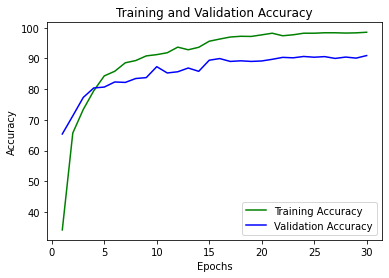

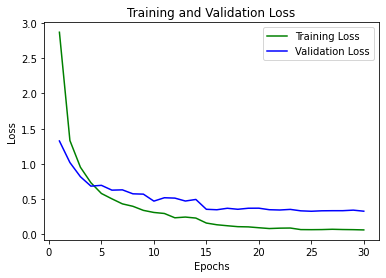

Test accuracy is: 90.52734375
Test loss is: 0.33543803205127065
__________________________________________________________________________________________________
---train/test split is:----
Train size is:4096, - 76,70,1
Eval size is:2045, - 53,45,43
Test size is:2048, - 26,74,85
----Start the trainig procedure---


100%|██████████| 4/4 [00:12<00:00,  3.13s/it]

\Evaluation set: Avg. loss: 1.4809, Accuracy: 1248/2045 (61.03%)




100%|██████████| 4/4 [00:11<00:00,  2.99s/it]

\Evaluation set: Avg. loss: 0.9949, Accuracy: 1451/2045 (70.95%)




100%|██████████| 4/4 [00:11<00:00,  3.00s/it]

\Evaluation set: Avg. loss: 0.8143, Accuracy: 1575/2045 (77.02%)




100%|██████████| 4/4 [00:11<00:00,  2.99s/it]

\Evaluation set: Avg. loss: 0.6257, Accuracy: 1670/2045 (81.66%)




100%|██████████| 4/4 [00:11<00:00,  2.97s/it]

\Evaluation set: Avg. loss: 0.5306, Accuracy: 1730/2045 (84.60%)




100%|██████████| 4/4 [00:11<00:00,  2.99s/it]

\Evaluation set: Avg. loss: 0.5362, Accuracy: 1723/2045 (84.25%)




100%|██████████| 4/4 [00:12<00:00,  3.02s/it]

\Evaluation set: Avg. loss: 0.4347, Accuracy: 1783/2045 (87.19%)




100%|██████████| 4/4 [00:11<00:00,  2.95s/it]

\Evaluation set: Avg. loss: 0.5905, Accuracy: 1706/2045 (83.42%)




100%|██████████| 4/4 [00:11<00:00,  2.95s/it]

\Evaluation set: Avg. loss: 0.5197, Accuracy: 1757/2045 (85.92%)




100%|██████████| 4/4 [00:11<00:00,  2.93s/it]

\Evaluation set: Avg. loss: 0.4535, Accuracy: 1781/2045 (87.09%)




100%|██████████| 4/4 [00:11<00:00,  2.96s/it]

\Evaluation set: Avg. loss: 0.4526, Accuracy: 1774/2045 (86.75%)

Epoch 00011: reducing learning rate of group 0 to 2.0000e-02.



100%|██████████| 4/4 [00:11<00:00,  2.98s/it]

\Evaluation set: Avg. loss: 0.3768, Accuracy: 1826/2045 (89.29%)




100%|██████████| 4/4 [00:11<00:00,  2.96s/it]

\Evaluation set: Avg. loss: 0.3477, Accuracy: 1844/2045 (90.17%)




100%|██████████| 4/4 [00:13<00:00,  3.31s/it]

\Evaluation set: Avg. loss: 0.3500, Accuracy: 1837/2045 (89.83%)




100%|██████████| 4/4 [00:11<00:00,  2.94s/it]

\Evaluation set: Avg. loss: 0.3443, Accuracy: 1848/2045 (90.37%)




100%|██████████| 4/4 [00:11<00:00,  2.95s/it]

\Evaluation set: Avg. loss: 0.3306, Accuracy: 1851/2045 (90.51%)




100%|██████████| 4/4 [00:11<00:00,  2.92s/it]

\Evaluation set: Avg. loss: 0.3437, Accuracy: 1849/2045 (90.42%)




100%|██████████| 4/4 [00:11<00:00,  2.94s/it]

\Evaluation set: Avg. loss: 0.3464, Accuracy: 1843/2045 (90.12%)




100%|██████████| 4/4 [00:11<00:00,  2.91s/it]

\Evaluation set: Avg. loss: 0.3383, Accuracy: 1848/2045 (90.37%)




100%|██████████| 4/4 [00:11<00:00,  2.93s/it]

\Evaluation set: Avg. loss: 0.3422, Accuracy: 1838/2045 (89.88%)

Epoch 00020: reducing learning rate of group 0 to 1.0000e-02.



100%|██████████| 4/4 [00:11<00:00,  2.92s/it]

\Evaluation set: Avg. loss: 0.3072, Accuracy: 1853/2045 (90.61%)




100%|██████████| 4/4 [00:11<00:00,  2.93s/it]

\Evaluation set: Avg. loss: 0.3082, Accuracy: 1855/2045 (90.71%)




100%|██████████| 4/4 [00:11<00:00,  2.99s/it]

\Evaluation set: Avg. loss: 0.2975, Accuracy: 1868/2045 (91.34%)




100%|██████████| 4/4 [00:11<00:00,  2.94s/it]

\Evaluation set: Avg. loss: 0.3076, Accuracy: 1861/2045 (91.00%)




100%|██████████| 4/4 [00:11<00:00,  2.94s/it]

\Evaluation set: Avg. loss: 0.2974, Accuracy: 1869/2045 (91.39%)




100%|██████████| 4/4 [00:11<00:00,  2.96s/it]

\Evaluation set: Avg. loss: 0.2958, Accuracy: 1866/2045 (91.25%)




100%|██████████| 4/4 [00:12<00:00,  3.00s/it]

\Evaluation set: Avg. loss: 0.2944, Accuracy: 1879/2045 (91.88%)




100%|██████████| 4/4 [00:11<00:00,  2.97s/it]

\Evaluation set: Avg. loss: 0.2975, Accuracy: 1876/2045 (91.74%)




100%|██████████| 4/4 [00:11<00:00,  2.98s/it]

\Evaluation set: Avg. loss: 0.2856, Accuracy: 1876/2045 (91.74%)




100%|██████████| 4/4 [00:11<00:00,  3.00s/it]


\Evaluation set: Avg. loss: 0.2945, Accuracy: 1876/2045 (91.74%)

----End of trainig procedure---


100%|██████████| 4/4 [00:12<00:00,  3.01s/it]



Test set: Avg. loss: 0.3410, Accuracy: 1851/2048 (90.38%)



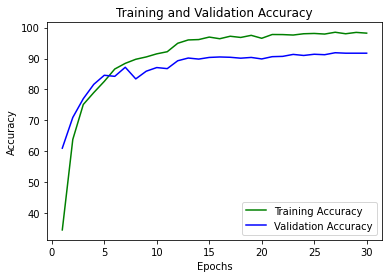

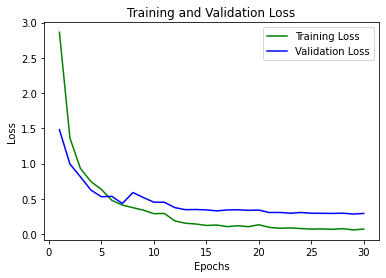

Test accuracy is: 90.380859375
Test loss is: 0.34103697366784685
__________________________________________________________________________________________________


In [ ]:
num_of_epochs_resnet = 30
LR_resnet = 0.04
num_classes = 102

for seed in [0,1]:
  set_random_seed(seed)
  resnet18 = models.resnet18(pretrained=True)
  resnet18.fc = nn.Linear(512, num_classes)
  resnet18.to(device)

  train_acc_for_graph, train_loss_for_graph, test_acc_for_graph, test_loss_for_graph, val_acc_for_graph, val_loss_for_graph = run_network(resnet18, num_of_epochs_resnet, LR_resnet)
  creat_graphs(num_of_epochs_resnet, train_acc_for_graph, train_loss_for_graph, test_acc_for_graph, test_loss_for_graph, val_acc_for_graph, val_loss_for_graph)

---train/test split is:----
Train size is:4096, - 90,73,83
Eval size is:2045, - 45,67,14
Test size is:2048, - 93,82,13
----Start the trainig procedure---


Epoch 1:   0%|          | 0/128 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|██████████| 4/4 [00:11<00:00,  2.93s/it]

\Evaluation set: Avg. loss: 1.7915, Accuracy: 1150/2045 (56.23%)




100%|██████████| 4/4 [00:13<00:00,  3.27s/it]

\Evaluation set: Avg. loss: 0.9737, Accuracy: 1550/2045 (75.79%)




100%|██████████| 4/4 [00:11<00:00,  2.94s/it]

\Evaluation set: Avg. loss: 0.8609, Accuracy: 1569/2045 (76.72%)




100%|██████████| 4/4 [00:11<00:00,  2.93s/it]

\Evaluation set: Avg. loss: 0.6091, Accuracy: 1681/2045 (82.20%)




100%|██████████| 4/4 [00:11<00:00,  2.95s/it]

\Evaluation set: Avg. loss: 0.6437, Accuracy: 1658/2045 (81.08%)




100%|██████████| 4/4 [00:11<00:00,  3.00s/it]

\Evaluation set: Avg. loss: 0.5720, Accuracy: 1707/2045 (83.47%)




100%|██████████| 4/4 [00:13<00:00,  3.31s/it]

\Evaluation set: Avg. loss: 0.6133, Accuracy: 1701/2045 (83.18%)




100%|██████████| 4/4 [00:12<00:00,  3.03s/it]

\Evaluation set: Avg. loss: 0.4654, Accuracy: 1778/2045 (86.94%)




100%|██████████| 4/4 [00:11<00:00,  3.00s/it]

\Evaluation set: Avg. loss: 0.5829, Accuracy: 1730/2045 (84.60%)




100%|██████████| 4/4 [00:11<00:00,  2.96s/it]

\Evaluation set: Avg. loss: 0.5446, Accuracy: 1720/2045 (84.11%)




100%|██████████| 4/4 [00:11<00:00,  2.97s/it]

\Evaluation set: Avg. loss: 0.4275, Accuracy: 1782/2045 (87.14%)




100%|██████████| 4/4 [00:12<00:00,  3.03s/it]

\Evaluation set: Avg. loss: 0.4503, Accuracy: 1779/2045 (86.99%)




100%|██████████| 4/4 [00:11<00:00,  2.99s/it]

\Evaluation set: Avg. loss: 0.4322, Accuracy: 1791/2045 (87.58%)




100%|██████████| 4/4 [00:12<00:00,  3.03s/it]

\Evaluation set: Avg. loss: 0.4934, Accuracy: 1760/2045 (86.06%)




100%|██████████| 4/4 [00:12<00:00,  3.02s/it]

\Evaluation set: Avg. loss: 0.4265, Accuracy: 1814/2045 (88.70%)




100%|██████████| 4/4 [00:11<00:00,  2.99s/it]

\Evaluation set: Avg. loss: 0.4204, Accuracy: 1803/2045 (88.17%)




100%|██████████| 4/4 [00:11<00:00,  2.98s/it]

\Evaluation set: Avg. loss: 0.4043, Accuracy: 1818/2045 (88.90%)




100%|██████████| 4/4 [00:11<00:00,  2.96s/it]

\Evaluation set: Avg. loss: 0.4658, Accuracy: 1780/2045 (87.04%)




100%|██████████| 4/4 [00:11<00:00,  2.95s/it]

\Evaluation set: Avg. loss: 0.4055, Accuracy: 1823/2045 (89.14%)




100%|██████████| 4/4 [00:11<00:00,  2.97s/it]

\Evaluation set: Avg. loss: 0.4110, Accuracy: 1804/2045 (88.22%)




100%|██████████| 4/4 [00:12<00:00,  3.04s/it]

\Evaluation set: Avg. loss: 0.4037, Accuracy: 1829/2045 (89.44%)




100%|██████████| 4/4 [00:11<00:00,  2.99s/it]

\Evaluation set: Avg. loss: 0.4098, Accuracy: 1803/2045 (88.17%)




100%|██████████| 4/4 [00:12<00:00,  3.02s/it]

\Evaluation set: Avg. loss: 0.4119, Accuracy: 1815/2045 (88.75%)




100%|██████████| 4/4 [00:12<00:00,  3.02s/it]

\Evaluation set: Avg. loss: 0.3860, Accuracy: 1822/2045 (89.10%)




100%|██████████| 4/4 [00:12<00:00,  3.03s/it]

\Evaluation set: Avg. loss: 0.3890, Accuracy: 1811/2045 (88.56%)




100%|██████████| 4/4 [00:12<00:00,  3.01s/it]

\Evaluation set: Avg. loss: 0.3620, Accuracy: 1839/2045 (89.93%)




100%|██████████| 4/4 [00:12<00:00,  3.02s/it]

\Evaluation set: Avg. loss: 0.4115, Accuracy: 1809/2045 (88.46%)




100%|██████████| 4/4 [00:11<00:00,  2.99s/it]

\Evaluation set: Avg. loss: 0.4176, Accuracy: 1814/2045 (88.70%)




100%|██████████| 4/4 [00:12<00:00,  3.15s/it]

\Evaluation set: Avg. loss: 0.3724, Accuracy: 1839/2045 (89.93%)




100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


\Evaluation set: Avg. loss: 0.3546, Accuracy: 1835/2045 (89.73%)

----End of trainig procedure---


100%|██████████| 4/4 [00:11<00:00,  2.98s/it]



Test set: Avg. loss: 0.3707, Accuracy: 1849/2048 (90.28%)



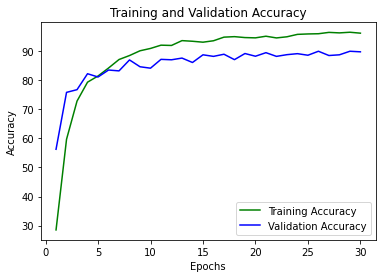

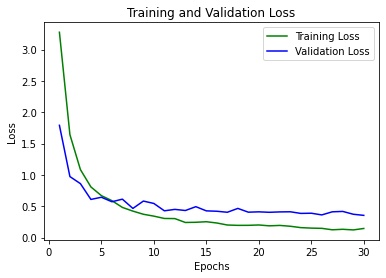

Test accuracy is: 90.283203125
Test loss is: 0.37066572169967094
__________________________________________________________________________________________________
---train/test split is:----
Train size is:4096, - 76,70,1
Eval size is:2045, - 53,45,43
Test size is:2048, - 26,74,85
----Start the trainig procedure---


Epoch 1:   0%|          | 0/128 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|██████████| 4/4 [00:12<00:00,  3.03s/it]

\Evaluation set: Avg. loss: 1.8033, Accuracy: 1177/2045 (57.56%)




100%|██████████| 4/4 [00:12<00:00,  3.00s/it]

\Evaluation set: Avg. loss: 1.1522, Accuracy: 1461/2045 (71.44%)




 50%|█████     | 2/4 [00:06<00:05,  2.64s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_worke

\Evaluation set: Avg. loss: 0.8083, Accuracy: 1610/2045 (78.73%)




 50%|█████     | 2/4 [00:06<00:05,  2.69s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_worke

\Evaluation set: Avg. loss: 0.6765, Accuracy: 1688/2045 (82.54%)




 50%|█████     | 2/4 [00:06<00:05,  2.63s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_worke

\Evaluation set: Avg. loss: 0.6651, Accuracy: 1661/2045 (81.22%)




 50%|█████     | 2/4 [00:06<00:05,  2.64s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_worke

\Evaluation set: Avg. loss: 0.5395, Accuracy: 1748/2045 (85.48%)




 50%|█████     | 2/4 [00:06<00:05,  2.69s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_worke

\Evaluation set: Avg. loss: 0.4980, Accuracy: 1759/2045 (86.01%)




 50%|█████     | 2/4 [00:06<00:05,  2.66s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_worke

\Evaluation set: Avg. loss: 0.4978, Accuracy: 1751/2045 (85.62%)




 50%|█████     | 2/4 [00:06<00:05,  2.60s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/

\Evaluation set: Avg. loss: 0.5104, Accuracy: 1752/2045 (85.67%)




Epoch 10:  94%|█████████▍| 120/128 [00:28<00:01,  4.15it/s, Loss: 0.3416, accuracy: 90.63]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/

\Evaluation set: Avg. loss: 0.4420, Accuracy: 1800/2045 (88.02%)




 50%|█████     | 2/4 [00:06<00:05,  2.64s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_worke

\Evaluation set: Avg. loss: 0.5051, Accuracy: 1756/2045 (85.87%)




Epoch 12:  74%|███████▍  | 95/128 [00:23<00:08,  4.04it/s, Loss: 0.318, accuracy: 91.28]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/da

\Evaluation set: Avg. loss: 0.3950, Accuracy: 1817/2045 (88.85%)




Epoch 13:  62%|██████▎   | 80/128 [00:19<00:10,  4.45it/s, Loss: 0.2483, accuracy: 93.36]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

\Evaluation set: Avg. loss: 0.3974, Accuracy: 1836/2045 (89.78%)




Epoch 14:  70%|██████▉   | 89/128 [00:21<00:09,  3.98it/s, Loss: 0.2232, accuracy: 93.96]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

\Evaluation set: Avg. loss: 0.4309, Accuracy: 1804/2045 (88.22%)




Epoch 15:  66%|██████▋   | 85/128 [00:20<00:09,  4.42it/s, Loss: 0.2142, accuracy: 94.19]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

\Evaluation set: Avg. loss: 0.3660, Accuracy: 1845/2045 (90.22%)




Epoch 16:  56%|█████▋    | 72/128 [00:17<00:12,  4.43it/s, Loss: 0.1941, accuracy: 94.75]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
Epoch 16:  57%|█████▋    | 73/128 [00:17<00:14,  3.93it/s, Loss: 0.1945, accuracy: 94.61]  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    s

\Evaluation set: Avg. loss: 0.4733, Accuracy: 1774/2045 (86.75%)




Epoch 17:  52%|█████▏    | 67/128 [00:16<00:14,  4.11it/s, Loss: 0.1944, accuracy: 94.4]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/da

\Evaluation set: Avg. loss: 0.3656, Accuracy: 1850/2045 (90.46%)




Epoch 18:  45%|████▌     | 58/128 [00:14<00:15,  4.54it/s, Loss: 0.1596, accuracy: 95.42]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Epoch 18:  45%|████▌     | 58/128 [00:14<00:15,  4.54it/s, Loss: 0.1595, accuracy: 95.39]    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
Epoch 18:  46%|████▌     | 59/128 [00:14<00:17,  3.84it/s, Loss: 0.1595, accuracy: 95.39]    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local

\Evaluation set: Avg. loss: 0.4056, Accuracy: 1806/2045 (88.31%)




Epoch 19:  34%|███▍      | 44/128 [00:10<00:19,  4.37it/s, Loss: 0.1698, accuracy: 95.67]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Epoch 19:  35%|███▌      | 45/128 [00:11<00:20,  4.09it/s, Loss: 0.1676, accuracy: 95.62]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib

\Evaluation set: Avg. loss: 0.3563, Accuracy: 1847/2045 (90.32%)




Epoch 20:  31%|███▏      | 40/128 [00:10<00:29,  2.96it/s, Loss: 0.166, accuracy: 95.62]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/da

\Evaluation set: Avg. loss: 0.3700, Accuracy: 1836/2045 (89.78%)




Epoch 21:  38%|███▊      | 49/128 [00:12<00:20,  3.80it/s, Loss: 0.1746, accuracy: 95.09]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

\Evaluation set: Avg. loss: 0.3564, Accuracy: 1837/2045 (89.83%)




Epoch 22:  30%|██▉       | 38/128 [00:09<00:19,  4.69it/s, Loss: 0.2453, accuracy: 93.59]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

\Evaluation set: Avg. loss: 0.4104, Accuracy: 1819/2045 (88.95%)




Epoch 23:   9%|▉         | 12/128 [00:03<00:26,  4.45it/s, Loss: 0.124, accuracy: 96.35]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/da

\Evaluation set: Avg. loss: 0.4237, Accuracy: 1805/2045 (88.26%)

Epoch 00023: reducing learning rate of group 0 to 3.0000e-02.



Epoch 24:   5%|▍         | 6/128 [00:01<00:31,  3.82it/s, Loss: 0.1209, accuracy: 94.79]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py",

\Evaluation set: Avg. loss: 0.3284, Accuracy: 1864/2045 (91.15%)




Epoch 25:   8%|▊         | 10/128 [00:02<00:25,  4.71it/s, Loss: 0.1067, accuracy: 96.56]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only 

\Evaluation set: Avg. loss: 0.3200, Accuracy: 1864/2045 (91.15%)




Epoch 26:   2%|▏         | 3/128 [00:01<00:46,  2.68it/s, Loss: 0.02137, accuracy: 100.0]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

\Evaluation set: Avg. loss: 0.3233, Accuracy: 1866/2045 (91.25%)




Epoch 27:   1%|          | 1/128 [00:00<01:43,  1.22it/s, Loss: 0.0, accuracy: 96.88]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Tracebac

\Evaluation set: Avg. loss: 0.3401, Accuracy: 1863/2045 (91.10%)




Epoch 28:   2%|▏         | 3/128 [00:01<00:40,  3.07it/s, Loss: 0.0605, accuracy: 98.96]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/da

\Evaluation set: Avg. loss: 0.3158, Accuracy: 1868/2045 (91.34%)




Epoch 29:   0%|          | 0/128 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e3d3ffef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/

\Evaluation set: Avg. loss: 0.3340, Accuracy: 1858/2045 (90.86%)




100%|██████████| 4/4 [00:12<00:00,  3.01s/it]


\Evaluation set: Avg. loss: 0.3102, Accuracy: 1874/2045 (91.64%)

----End of trainig procedure---


100%|██████████| 4/4 [00:11<00:00,  2.98s/it]



Test set: Avg. loss: 0.3320, Accuracy: 1867/2048 (91.16%)



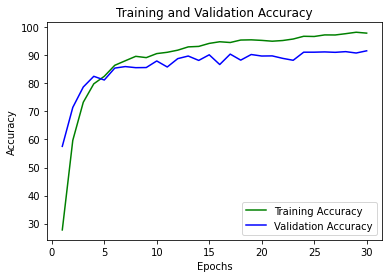

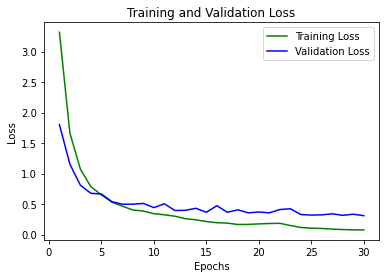

Test accuracy is: 91.162109375
Test loss is: 0.3319807771085305
__________________________________________________________________________________________________


In [ ]:
num_of_epochs_google = 30
LR_google = 0.06
num_classes = 102

for seed in [0,1]:
  set_random_seed(seed)          
  googlenet = models.googlenet(pretrained=True)
  googlenet.fc = nn.Linear(1024, num_classes)
  googlenet.to(device)

  train_acc_for_graph, train_loss_for_graph, test_acc_for_graph, test_loss_for_graph, val_acc_for_graph, val_loss_for_graph = run_network(googlenet, num_of_epochs_google, LR_google)
  creat_graphs(num_of_epochs_google, train_acc_for_graph, train_loss_for_graph, test_acc_for_graph, test_loss_for_graph, val_acc_for_graph, val_loss_for_graph)